Hasta ahora, hemos trabajado considerando el ángulo de polarización calculado como diferencias de ángulos, incluyendo el ángulo de polarización intrínseco (el cual es desconocido). Como consecuencia, estamos arrastrando errores sistemáticos en los datos y es necesario la realización de un pre-procesamiento.

Es decir, debemos comprobar si la siguiente consideración: $ \psi = \psi _0 + RM \lambda^2 $ es correcta.

Para ello, estudiamos la medida de rotación para diferencias reales del ángulo de polarización, estableciendo nuestro cero en 11 GHz. Para dar por válidos nuestros cálculos, recordemos que la RM es una constante y debe ser independiente de la frecuencia.

Una vez obtenida esta, estudiamos la **"signal-to-noise ratio"** para observar los píxeles significativos.

Lo que se busca es eliminar el ángulo de polarización intrínseco, por eso las diferencias. 
La radiación del sincrotrón que se percibe pertenece a toda la línea de visión (línea infinita), donde tenemos campos magnéticos tanto delante como atrás de esta. Es por ello que se produce una rotación adicional (ángulo intrínseco), creada por el hecho de ser una radiación polarizada linealmente.

In [18]:
%matplotlib inline

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

##############################################################################
# BLOQUE 1: SENSIBILIDAD NORMALIZADA PARA Q
##############################################################################

# Definimos la función que calcula la sensibilidad normalizada para Q

def normsigQ(sig0, hitsQ):

    """
        La sensibilidad normalizada para Q se calcula con la siguiente expresión:
        σ= σ_0 / sqrt(hitsQ)
    
    """
    
    sigQ = sig0 / np.sqrt(hitsQ)
    return sigQ

# Creamos un diccionario donde introducimos los valores de sensibilidad característica (sig0Q) para Q

sig0Q_values = {
    11: 1.371,                # 11 GHz => H3
    13: 1.188,                # 13 GHz => H3
    17: (1.878 + 1.101) / 2,  # 17 GHz => promedio H2, H4
    19: (2.280 + 1.059) / 2   # 19 GHz => promedio H2, H4
}

frecuencias = [11, 13, 17, 19]
sensQ_maps = {}  # Diccionario donde almacenaremos los mapas resultantes

# Iteramos sobre las frecuencias para calcular la sensibilidad normalizada para Q

for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    # Leemos la sensibilidad característica para Q de cada una de las frecuencias
    # y el mapa de hits correspondiente

    sig0Q = sig0Q_values[freq]
    
    hitsQU = hp.read_map(archivo, field=4)
    
    # Calculamos la sensibilidad normalizada llamando a la función definida previamente
    # y guardamos en el diccionario para cada interacción (frecuencia)
    
    sigQ_norm = normsigQ(sig0Q, hitsQU)
    
    sensQ_maps[freq] = sigQ_norm

# # A continuación, definimos una función para graficar los mapas de sensibilidad normalizada Q y,
# # finalmente, los representamos.

# def plot_map_Q(map_data, freq):
#     hp.mollview(
#         map_data, 
#         title=f'Sensibilidad Normalizada Q ( $\sigma_Q$ ) para {freq} GHz',
#         unit='$mK \, s^{1/2}$',
#         cmap='hsv'
#     )
#     hp.graticule()
#     plt.show()

# for freq, map_data in sensQ_maps.items():
#     plot_map_Q(map_data, freq)

/tmp/ipykernel_12805/1087121070.py:21: RuntimeWarning: invalid value encountered in sqrt
  sigQ = sig0 / np.sqrt(hitsQ)


In [19]:
##############################################################################
# BLOQUE 2: SENSIBILIDAD NORMALIZADA PARA U
##############################################################################

# En este bloque, el cálculo es análogo al del bloque anterior, pero para la sensibilidad normalizada de U.

def normsigU(sig0, hitsU):
    
    sigU = sig0 / np.sqrt(hitsU)
    return sigU

sig0U_values = {
    11: 1.372,                 # 11 GHz
    13: 1.188,                 # 13 GHz
    17: (1.875 + 1.100) / 2,   # 17 GHz => promedio H2, H4
    19: (2.273 + 1.064) / 2    # 19 GHz => promedio H2, H4
}

sensU_maps = {}  

for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    sig0U = sig0U_values[freq]
  
    hitsQU = hp.read_map(archivo, field=4)
    
    sigU_norm = normsigU(sig0U, hitsQU)
    
    sensU_maps[freq] = sigU_norm

# def plot_map_U(map_data, freq):
#     hp.mollview(
#         map_data, 
#         title=f'Sensibilidad Normalizada U ( $\sigma_U$ ) para {freq} GHz',
#         unit='$mK \, s^{1/2}$',
#         cmap='hsv'
#     )
#     hp.graticule()
#     plt.show()

# for freq, map_data in sensU_maps.items():
#     plot_map_U(map_data, freq)

/tmp/ipykernel_12805/2473048668.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigU = sig0 / np.sqrt(hitsU)


In [20]:
##############################################################################
# BLOQUE 3: PROPAGACIÓN DE ERROR DE LA FUNCIÓN DIFPSI
##############################################################################

# Comenzamos definiendo la función difpsi, que calcula el ángulo de polarización a partir de los mapas Q y U.

def difpsi(Q, U):

    """
       El ángulo de polarización lineal ψ se calcula a partir de los parámetros de Stokes, Q y U, 
       que hacen referencia a la polarización lineal y a la polarización en 45 grados, respectivamente.
       La relación de los parámetros con el ángulo se expresa como:

         ψ = (1/2) * arcotangente (U / Q) + π/2 

       La suma de π/2 se añade para ajustar los límites del ángulo de polarización. 
       La polarización lineal solo tiene sentido como una dirección de eje, sin orientación de flecha, de modo que el ángulo de polarización es intrínsecamente periódico de 180°.  

    """

    psi = 0.5 * np.arctan2(U, Q) + np.pi/2
    return psi

# A continuación, definimos otra función para calcular la incertidumbre en psi (propagación de errores):

def difpsi_error(Q, U, sigma_Q, sigma_U):
    
    """
        Calcula σ₍ψ₎ para cada píxel, a partir de Q, U, σ_Q y σ_U.
        Para ello, aplicamos propagación de errores a la función difpsi(Q, U). 
        Es decir, calculamos la derivada de ψ respecto a Q y U, y luego aplicamos la fórmula de propagación de errores, que es:
            
            σ₍ψ₎ = sqrt( (∂ψ/∂U)² * σ_U² + (∂ψ/∂Q)² * σ_Q² )

        siendo la derivada de la arcotangente: ∂/∂x [arctan (A)] = (∂A/∂x) / (1 + A²)

        Calculada cada derivada parcial, finalmente nos queda:

             σ₍ψ₎ = sqrt( (0.5*Q/(Q^2+U^2))² * σ_U² + (0.5*U/(Q^2+U^2))² * σ_Q² ).

    """
    denom = Q**2 + U**2

    # Para evitar división por cero, se pueden enmascarar los píxeles con denominador cercano a 0.
    # Aquí, usamos np.where para evitar problemas:

    """
        La función np.where es un condicional que nos facilita Numpy, tiene la siguiente estructura:
        np.where(condición, valor_si_verdadero, valor_si_falso)
        En este caso, si el denominador es diferente de cero, se calcula la derivada,
        de lo contrario se asigna 0 para evitar la división por cero.

    """

    dpsi_dU = 0.5 * np.where(denom!=0, Q/denom, 0)
    dpsi_dQ = 0.5 * np.where(denom!=0, -U/denom, 0)
    
    sigma_psi_sq = (dpsi_dU**2)*(sigma_U**2) + (dpsi_dQ**2)*(sigma_Q**2)
    sigma_psi = np.sqrt(sigma_psi_sq)
    return sigma_psi

# Bucle sobre las frecuencias para calcular y graficar ψ y su incertidumbre

for freq in frecuencias:
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    
    # Leemos los mapas de los parámetros Q y U
    mapQ = hp.read_map(archivo, field=1)
    mapU = hp.read_map(archivo, field=2)
    
    # Llamamos a la función difpsi para calcular el ángulo de polarización

    psi = difpsi(mapQ, mapU)
    
    # Definimos los errores de Q y U, previamente calculados, para cada frecuencia

    sigma_Q = sensQ_maps[freq] 
    sigma_U = sensU_maps[freq]  
    
    # Llamamos a la función difpsi_error para calcular la incertidumbre en el ángulo de polarización

    sigma_psi = difpsi_error(mapQ, mapU, sigma_Q, sigma_U)
    
    # # Visualizamos el mapa de la incertidumbre en psi
   
    # hp.mollview(sigma_psi,
    #             title=f"Incertidumbre en ángulo de polarización ( $\sigma_\psi$ ) a {freq} GHz",
    #             unit="rad",
    #             cmap="hsv",
    #             min=0,max=np.pi)
    # hp.graticule()
    # plt.show()

/tmp/ipykernel_12805/2589864971.py:42: RuntimeWarning: overflow encountered in square
  denom = Q**2 + U**2


/tmp/ipykernel_12805/2589864971.py:42: RuntimeWarning: overflow encountered in square
  denom = Q**2 + U**2


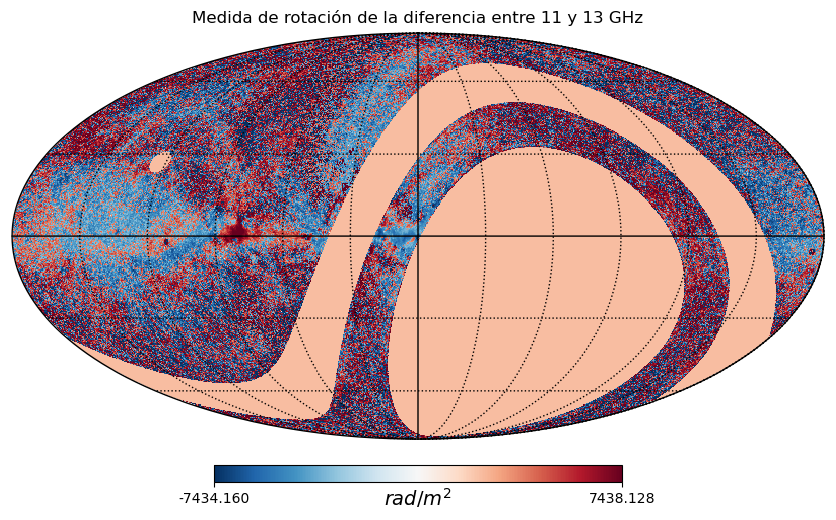

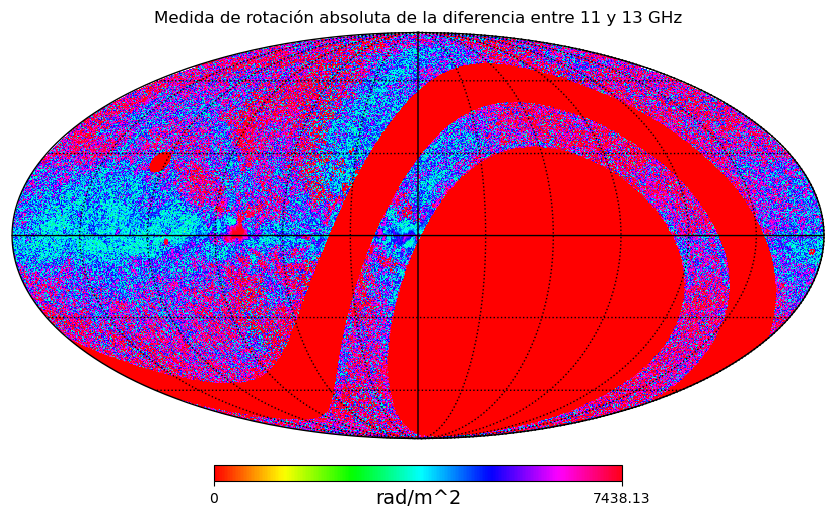

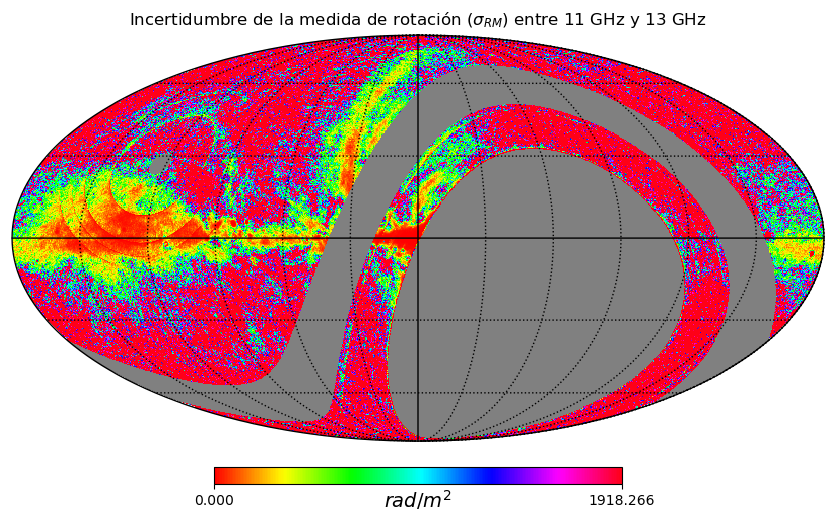

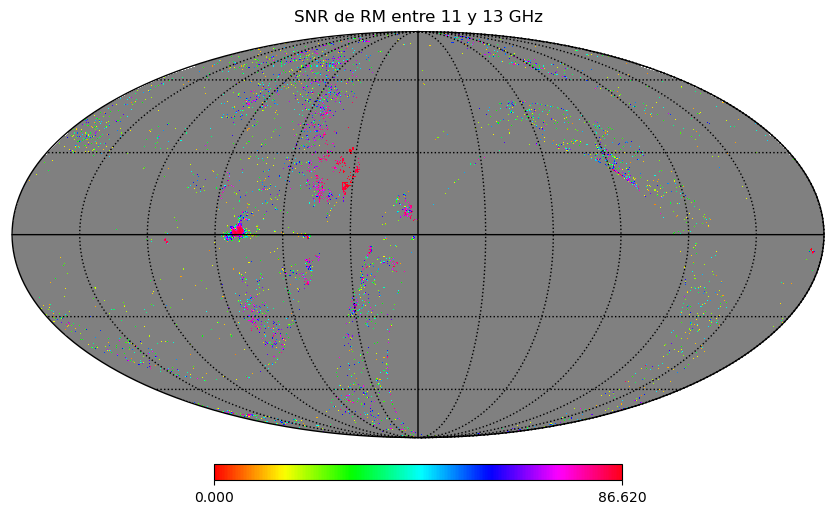

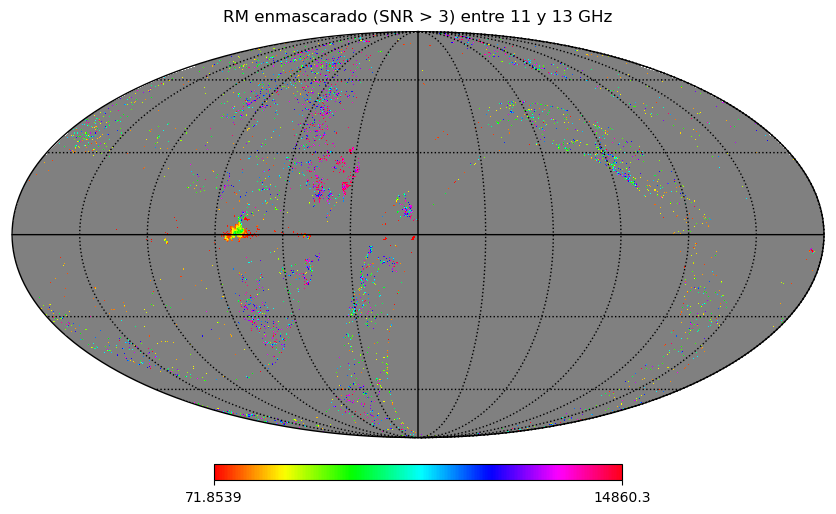

Píxeles observados por QUIJOTE a 13 GHz: 9319170
Píxeles con SNR > 3: 56882
Porcentaje sobre observados: 0.61%


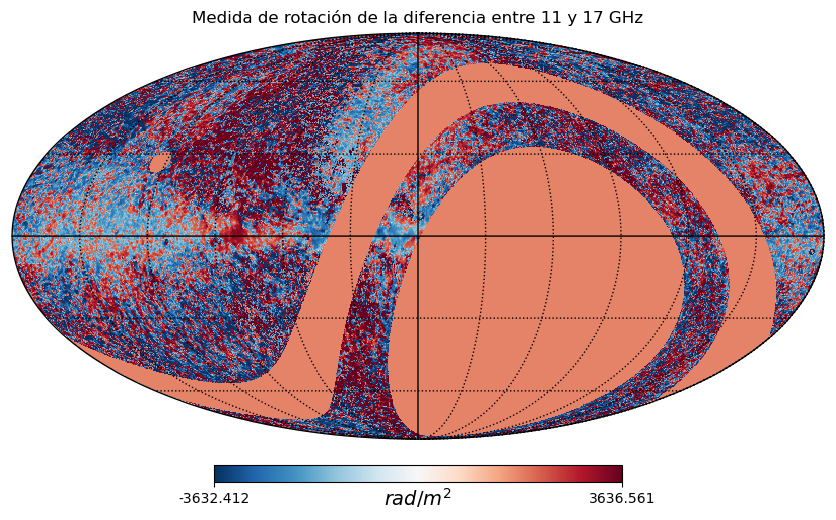

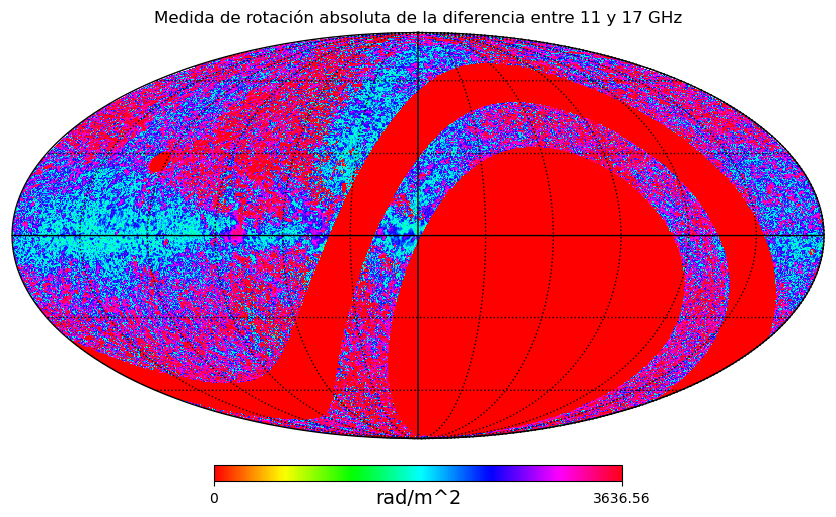

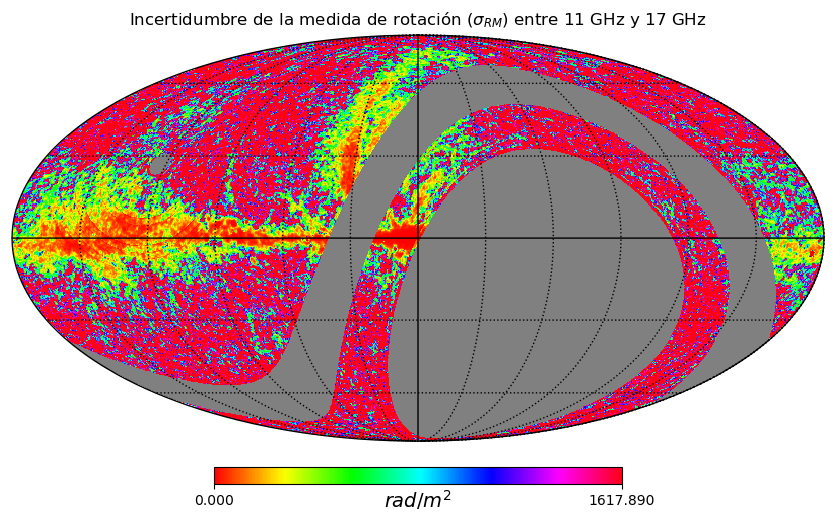

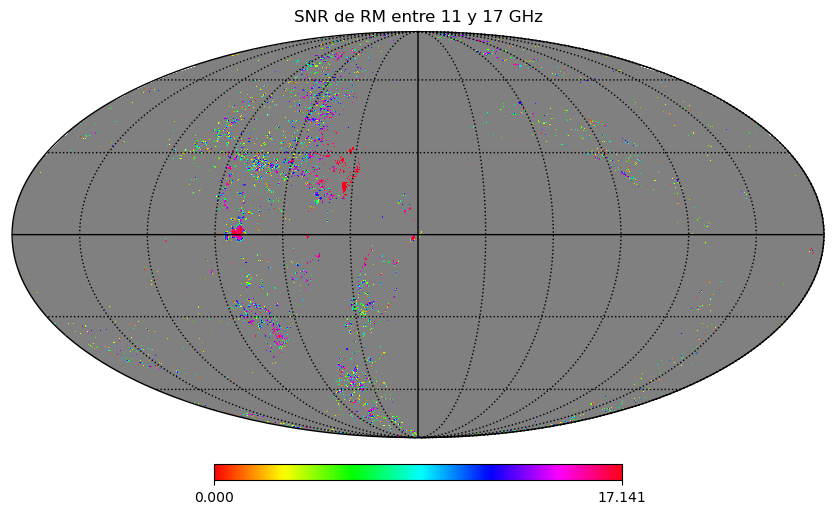

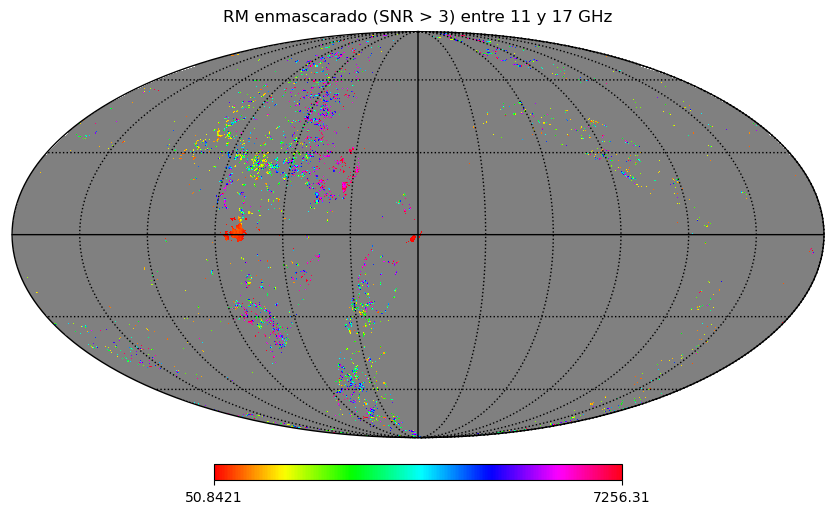

Píxeles observados por QUIJOTE a 17 GHz: 9320325
Píxeles con SNR > 3: 60994
Porcentaje sobre observados: 0.65%


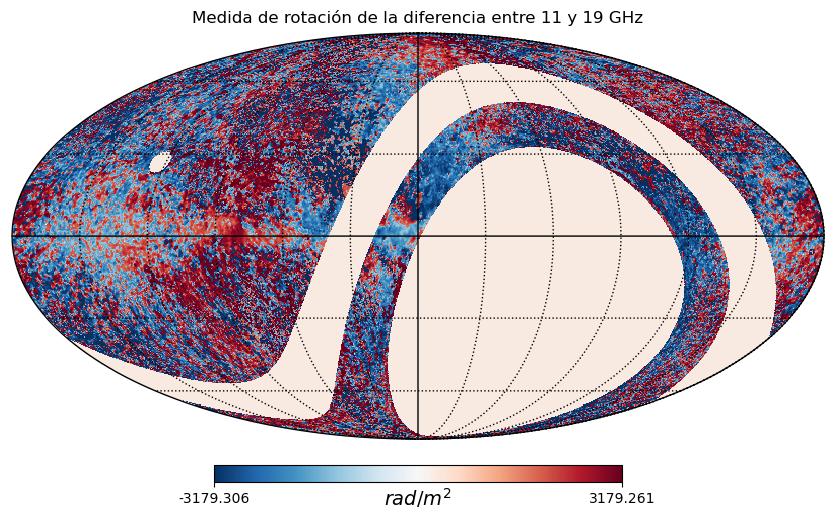

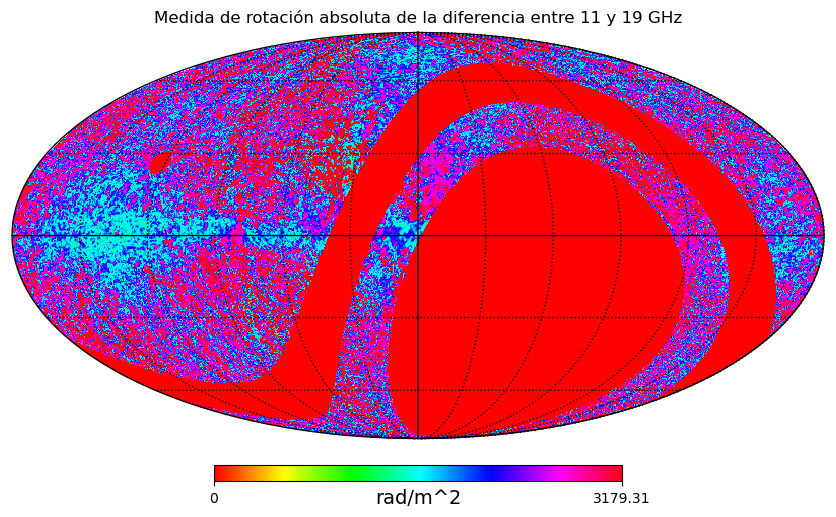

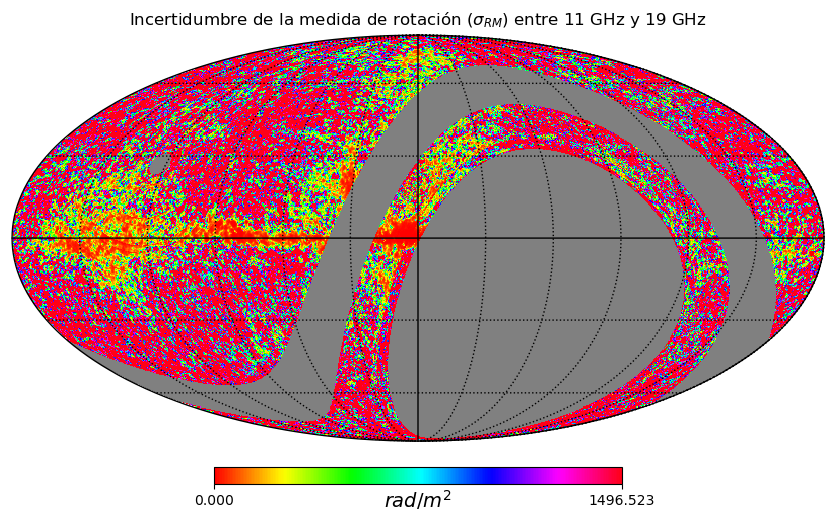

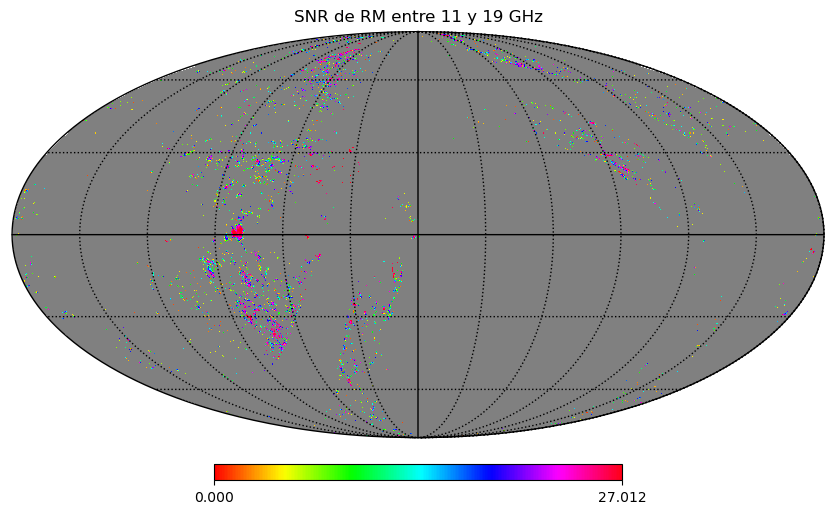

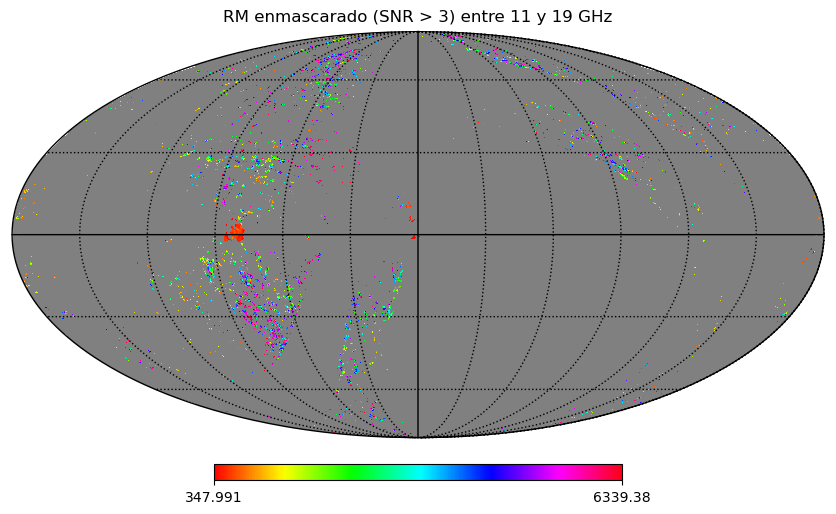

Píxeles observados por QUIJOTE a 19 GHz: 9320166
Píxeles con SNR > 3: 59551
Porcentaje sobre observados: 0.64%


In [21]:
##############################################################################
# BLOQUE 4: RM ENTRE 11 GHz Y OTRAS FRECUENCIAS
##############################################################################

# En este bloque vamos a calcular la medida de rotación de Faraday a partir de las
# diferencias de los ángulos de polarización.
# Esto lo hacemos para eliminar la rotación intrínseca considerada en el cálculo de psi.

"""
    La medida de rotación de Faraday (RM) queda como:
    RM = (ψ₁ - ψ₂) / (λ₁² - λ₂²)
    donde ψ₁ y ψ₂ son los ángulos de polarización y, λ₁ y λ₂, sus longitudes de onda, respectivamente.
    Como ángulo de polarización de referencia, ψ₁, tomamos el medido a 11 GHz.

"""

freq_ref = 11

# Para la obtención de la longitud de onda de referencia, λ₁, aplicamos la relación entre la velocidad de la luz y la frecuencia:

lambda_ref = 299792458.0 / (freq_ref * 1e9)  # Convertimos GHz a Hz

# Definimos todas las variables necesarias para el ángulo de referencia

archivo_ref = f"quijote_mfi_smth_skymap_{freq_ref}ghz_512_dr1.fits"
mapQ_ref = hp.read_map(archivo_ref, field=1)
mapU_ref = hp.read_map(archivo_ref, field=2)
psi_ref = difpsi(mapQ_ref, mapU_ref)
sigma_Q_ref = sensQ_maps[freq_ref]
sigma_U_ref = sensU_maps[freq_ref]
sigma_psi_ref = difpsi_error(mapQ_ref, mapU_ref, sigma_Q_ref, sigma_U_ref)

# Guardamos los mapas para el cálculo de residuos

RM_maps = {}          # p.ej. RM_maps[13] = RM(11-13)

# Bucle sobre las frecuencias para calcular RM y su error

for freq in [13, 17, 19]:

    lambda_freq = 299792458.0 / (freq * 1e9)  
    archivo = f"quijote_mfi_smth_skymap_{freq}ghz_512_dr1.fits"
    mapQ = hp.read_map(archivo, field=1)
    mapU = hp.read_map(archivo, field=2)
    psi = difpsi(mapQ, mapU)
    sigma_Q = sensQ_maps[freq]
    sigma_U = sensU_maps[freq]
    sigma_psi = difpsi_error(mapQ, mapU, sigma_Q, sigma_U)

    # Definimos las diferencias mencionadas

    delta_psi = psi_ref - psi
    delta_lambda2 = lambda_ref**2 - lambda_freq**2

    # Cálculo de RM y su error

    RM = delta_psi / delta_lambda2
    sigma_RM = np.sqrt(sigma_psi_ref**2 + sigma_psi**2) / np.abs(delta_lambda2)

    # Guarda resultados por frecuencia

    RM_maps[freq] = RM

    # Visualización del mapa de RM y su error

    hp.mollview(RM,
                title=f"Medida de rotación de la diferencia entre 11 y {freq} GHz",
                unit="$rad/m^2$",
                cmap="RdBu_r",
                norm= "hist",
                format="%.3f",
                min=np.nanmin(RM)/2,max=np.nanmax(RM)/2)
    hp.graticule()
    plt.show()

    hp.mollview(np.abs(RM),
                    title=f"Medida de rotación absoluta de la diferencia entre 11 y {freq} GHz",
                    unit="rad/m^2",
                    cmap="hsv",
                    norm= "hist",
                    min=np.nanmin(np.abs(RM))/2,max=np.nanmax(np.abs(RM))/2)
    hp.graticule()
    plt.show()

    hp.mollview(sigma_RM,
                title=r"Incertidumbre de la medida de rotación ($\sigma_{RM}$)" f" entre 11 GHz y {freq} GHz",
                unit="$rad/m^2$",
                cmap="hsv",
                format="%.3f",
                norm="hist",
                min=0,max=max(sigma_RM)/1000)  # Como el máximo es del orden del millón, bajamos tres órdenes de magnitud para reducir la escala.
    hp.graticule()
    plt.show()


    ##############################################################################
    # BLOQUE 5: OBTENCIÓN DEL SNR (SIGNAL TO NOISE RATIO)
    ##############################################################################

    SNR_RM = np.full_like(RM, hp.UNSEEN)
    mask = sigma_RM > 0
    SNR_RM[mask] = RM[mask] / sigma_RM[mask]

    umbral_snr = 3
    RM_masked = np.where(SNR_RM > umbral_snr, RM, hp.UNSEEN)
    SNR_masked = np.where(SNR_RM > umbral_snr, SNR_RM, hp.UNSEEN)

    hp.mollview(SNR_masked,
                title=f"SNR de RM entre 11 y {freq} GHz",
                cmap="hsv",
                norm= "hist",
                format="%.3f",
                min=0, max=max(SNR_masked)/10) ### PREGUNTAR POR EL PÚLSAR CRAB
    hp.graticule()
    plt.show()

    # Enmascaramos RM donde SNR < 3
    hp.mollview(RM_masked,
                title=f"RM enmascarado (SNR > {umbral_snr}) entre 11 y {freq} GHz",
                cmap="hsv",
                norm="hist")
    hp.graticule()
    plt.show()

    # Para saber el número de píxeles totales observados por QUIJOTE, 
    # leemos el mapa original con todas sus columnas: 
    mapa=hp.read_map(archivo, field=(0,1,2,3,4)) 
    # Para asegurarnos que sean los píxeles OBSERVADOS, aplicamos la condición de que no sean UNSEEN:
    n_observados = np.sum(mapa != hp.UNSEEN)
    # Número de píxeles observados que cumplen el umbral de SNR
    n_umbral = np.sum(RM_masked != hp.UNSEEN)
    # Porcentaje
    porcentaje = 100 * n_umbral / n_observados if n_observados > 0 else 0

    print(f"Píxeles observados por QUIJOTE a {freq} GHz: {n_observados}")
    print(f"Píxeles con SNR > {umbral_snr}: {n_umbral}")
    print(f"Porcentaje sobre observados: {porcentaje:.2f}%")
    

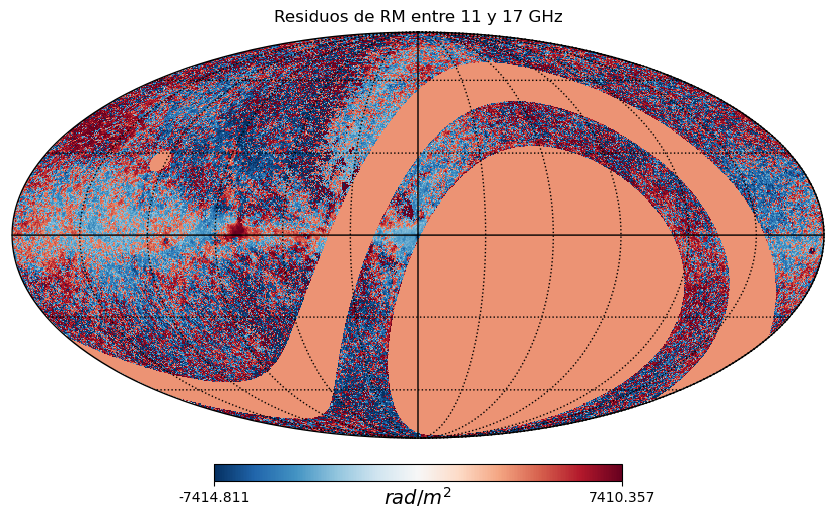

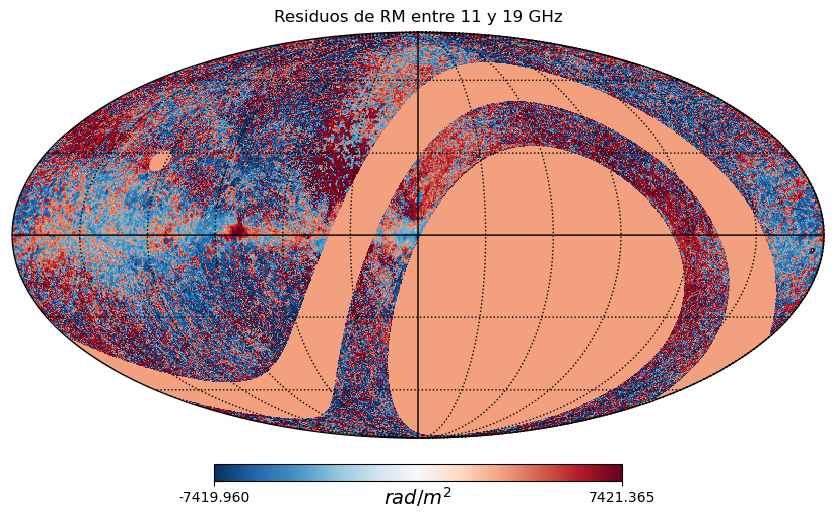

In [22]:
    ##############################################################################
    #                              CÁLCULO DE RESIDUOS                           #
    ##############################################################################

    # Asegura la operación píxel a píxel con las mismas máscaras NaN

    mask = np.isfinite(RM_maps[13]) & np.isfinite(RM_maps[17]) & np.isfinite(RM_maps[19])

    res_13_17 = np.full_like(RM_maps[13], np.nan)
    res_13_19 = np.full_like(RM_maps[13], np.nan)

    res_13_17[mask] = RM_maps[13][mask] - RM_maps[17][mask]   # RM(11-13) - RM(11-17)
    res_13_19[mask] = RM_maps[13][mask] - RM_maps[19][mask]   # RM(11-13) - RM(11-19)

    # Visualización de los mapas de residuos

    hp.mollview(res_13_17,
                title=f"Residuos de RM entre 11 y 17 GHz",
                unit="$rad/m^2$",
                cmap="RdBu_r",
                norm="hist",
                format="%.3f",
                min=np.nanmin(res_13_17)/2, max=np.nanmax(res_13_17)/2)
    hp.graticule()
    plt.show()

    hp.mollview(res_13_19,
                title=f"Residuos de RM entre 11 y 19 GHz",
                unit="$rad/m^2$",
                cmap="RdBu_r",
                norm="hist",
                format="%.3f",
                min=np.nanmin(res_13_19)/2, max=np.nanmax(res_13_19)/2)
    hp.graticule()
    plt.show()